In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = r"C:\Users\TomiNordi2m\OneDrive - i2m Unternehmensentwicklung GmbH\Documents\Python\Konrad\Konrad Energy Data Aggregated.xlsx"
# file_path = r"C:\Users\TomiNordi2m\OneDrive - i2m Unternehmensentwicklung GmbH\Documents\Python\Konrad\Konrad Energy Data Aggregated.xlsx"
excel_file = pd.ExcelFile(file_path)


# Load the data from the identified sheet
df = excel_file.parse('Tabelle1')

# Show the first few rows and column names to understand the structure
df.head()


,Date,Grid Consumption [kW],Grid Feed-in [kW],PV Production [kW],Load Profile [kW]
0,2024-01-01 00:00:00,7.32,0.0,0.0,7.32
1,2024-01-01 00:15:00,8.04,0.0,0.0,8.04
2,2024-01-01 00:30:00,7.74,0.0,0.0,7.74
3,2024-01-01 00:45:00,7.74,0.0,0.0,7.74
4,2024-01-01 01:00:00,6.84,0.0,0.0,6.84


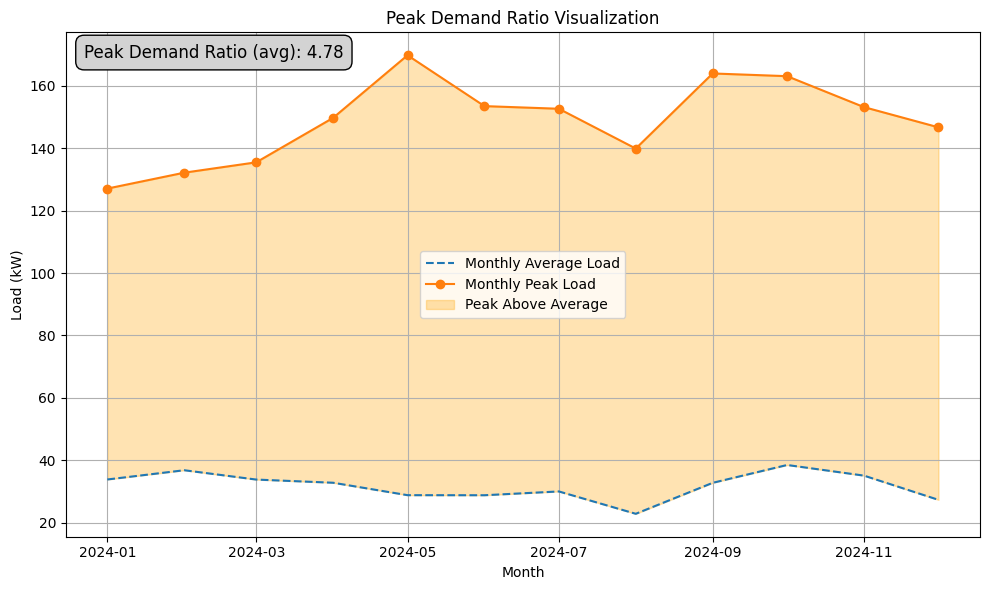

In [ ]:
# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group data by month
df['month'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby('month')['Load Profile [kW]'].mean()
monthly_peak = df.groupby('month')['Load Profile [kW]'].max()
monthly_dates = monthly_avg.index.to_timestamp()

# Convert to numpy arrays for plotting compatibility
monthly_dates = monthly_dates.to_numpy()
monthly_avg = monthly_avg.to_numpy()
monthly_peak = monthly_peak.to_numpy()

# peak demand ratio for display
peak_demand_ratio_value = (monthly_peak / monthly_avg).mean()

# Plot with KPI annotation
plt.figure(figsize=(10, 6))
plt.plot(monthly_dates, monthly_avg, label='Monthly Average Load', linestyle='--')
plt.plot(monthly_dates, monthly_peak, label='Monthly Peak Load', marker='o')
plt.fill_between(monthly_dates, monthly_avg, monthly_peak, color='orange', alpha=0.3, label='Peak Above Average')

# Add KPI text box
plt.text(
    0.02, 0.95,
    f"Peak Demand Ratio (avg): {peak_demand_ratio_value:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.title('Peak Demand Ratio Visualization')
plt.xlabel('Month')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



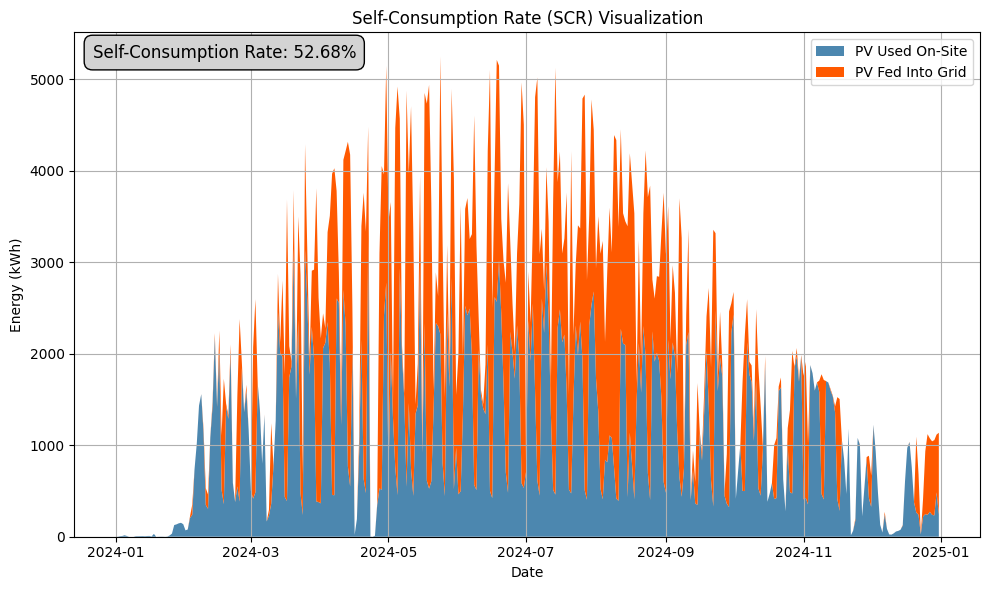

In [10]:

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Calculate PV used on-site (PV production - feed-in)
df['PV used [kW]'] = df['PV Production [kW]'] - df['Grid Feed-in [kW]']
df['PV used [kW]'] = df['PV used [kW]'].clip(lower=0)

# Aggregate daily totals
daily = df.groupby(df['Date'].dt.date)[['PV Production [kW]', 'PV used [kW]']].sum()

# Calculate Self-Consumption Rate
scr = daily['PV used [kW]'].sum() / daily['PV Production [kW]'].sum()

# Plotting
plt.figure(figsize=(10, 6))
plt.stackplot(
    daily.index,
    daily['PV used [kW]'],
    daily['PV Production [kW]'] - daily['PV used [kW]'],
    labels=['PV Used On-Site', 'PV Fed Into Grid'],
    colors=["#4C87AF", "#FF5900"]
)

plt.title('Self-Consumption Rate (SCR) Visualization')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend(loc='upper right')

# Add KPI annotation
plt.text(
    0.02, 0.95,
    f"Self-Consumption Rate: {scr:.2%}",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.grid(True)
plt.tight_layout()
plt.show()


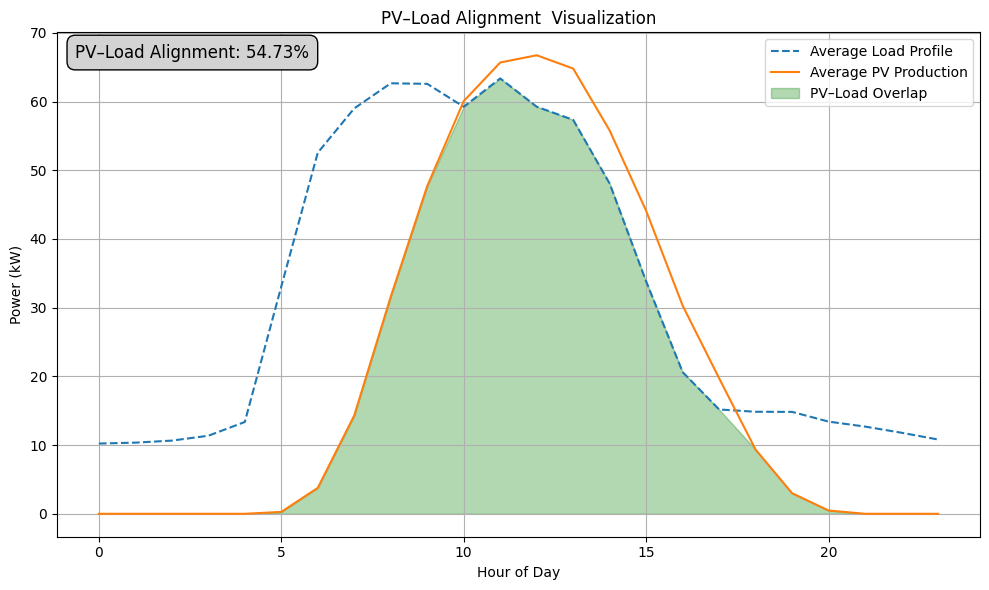

In [8]:
# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Rename for simplicity (optional)
df['timestamp'] = df['Date']
df['load'] = df['Load Profile [kW]']
df['pv_production'] = df['PV Production [kW]']

# --- Calculate PV–Load Alignment  ---
df['pv_used_direct'] = df[['load', 'pv_production']].min(axis=1)
lpai = df['pv_used_direct'].sum() / df['pv_production'].sum()

# --- Create average daily load and PV production profile ---
df['hour'] = df['timestamp'].dt.hour
average_profile = df.groupby('hour')[['load', 'pv_production']].mean()

# Prepare values for plotting
x_vals = average_profile.index.to_numpy()
load_vals = average_profile['load'].to_numpy()
pv_vals = average_profile['pv_production'].to_numpy()
overlap_vals = average_profile[['load', 'pv_production']].min(axis=1).to_numpy()

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(x_vals, load_vals, label='Average Load Profile', linestyle='--')
plt.plot(x_vals, pv_vals, label='Average PV Production', linestyle='-')
plt.fill_between(x_vals, overlap_vals, color='green', alpha=0.3, label='PV–Load Overlap')

# Add LPAI annotation
plt.text(
    0.02, 0.95,
    f"PV–Load Alignment: {lpai:.2%}",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.title('PV–Load Alignment  Visualization')
plt.xlabel('Hour of Day')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
